<a href="https://colab.research.google.com/github/ravindrabharathi/Project1/blob/master/ph2-s1/EVA_ph2_sess1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Train a Neural Network to classify IMDB reviews as postive/negative 

We use the refernce code from François Chollet's Deep Learning with Python book to train a Neural Network to classify IMBD reviews 

Large Movie Review Dataset(IMDB dataset) is a dataset for binary sentiment classification containing a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. 

It was first used in the paper 'Learning Word Vectors for Sentiment Analysis' by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011) for The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

The IMBD data has been downloaded from http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz and stored in Google drive. We will mount Google drive and copy the data to current working directory 

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!ls '/gdrive/My Drive/EVA/ph2'

s1


In [0]:
!cp '/gdrive/My Drive/EVA/ph2/s1/glove.6B.zip' ./

In [0]:
!cp '/gdrive/My Drive/EVA/ph2/s1/aclImdb_v1.tar.gz' ./

In [0]:
#!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

Create a folder named 'data' and unzip IMBD training and test data into this folder 

In [0]:
!mkdir 'data'


In [0]:
!tar -xf aclImdb_v1.tar.gz -C ./data/

Load training data - all text into a list called 'texts' and all labels into a list called 'labels' 

In [0]:
import os

imdb_dir = '/content/data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [9]:
print('Training data has',len(texts),'samples')

Training data has 25000 samples


Build train and validation data :

We will use the first 100 words of every review to train our network. We will also limit training samples to 8000 and validation samples to 10000. We will also consider only the top 10000 words in the dataset for this training 

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 8000  # We will be training on 8000 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

#create tokenizer and sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

#print number of unique tokens
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# pad sequences to max length of 100 so that all data is of same length
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples] #8000 samples for training
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples] # next 10000 samples for validation
y_val = labels[training_samples: training_samples + validation_samples]

Using TensorFlow backend.


Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


GloVe Embeddings

There are various precomputed databases of word embeddings that you can download and use in a Keras Embedding layer. One of them is 
Global Vectors for Word Representation (GloVe, https://nlp.stanford.edu/projects/glove), which was developed by Stanford researchers in 2014. This
embedding technique is based on factorizing a matrix of word co-occurrence statistics. Its developers have made available precomputed embeddings for millions of
English tokens, obtained from Wikipedia data and Common Crawl data.

GloVe embeddings have been downloaded from  http://nlp.stanford.edu/data/glove.6B.zip and stored in Google drive. We will unzip the embedding files into 'data' folder 

In [0]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip

In [12]:
!unzip glove.6B.zip -d ./data/

Archive:  glove.6B.zip
  inflating: ./data/glove.6B.50d.txt  
  inflating: ./data/glove.6B.100d.txt  
  inflating: ./data/glove.6B.200d.txt  
  inflating: ./data/glove.6B.300d.txt  


Load and parse the word embeddings from GloVe . Use the 100 dimensional embedding vectors found in 'glove.6B.100d.txt'

In [13]:
glove_dir = '/content/data/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt')) #use 100 dimensional emdedding vectors 
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Build an embedding matrix that you can load into an Embedding layer. It
must be a matrix of shape (max_words, embedding_dim)

In [0]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

Define the Model 

In [15]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


Load pretrained word embeddings into the Embedding layer and freeze the embedding layer so that the pretrained parts aren’t
updated during training, to avoid forgetting what they already know.

In [16]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Compile the model and train for 10 epochs. Use rmsprop optimizer with binary crossentropy loss function to train the model 

Save the model weights to file 'pre_trained_glove_model.h5'

In [17]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8000 samples, validate on 10000 samples
Epoch 1/10
8000/8000 [==============================] - 3s 374us/step - loss: 0.7093 - acc: 0.5770 - val_loss: 0.6540 - val_acc: 0.6510
Epoch 2/10
8000/8000 [==============================] - 1s 143us/step - loss: 0.6179 - acc: 0.6738 - val_loss: 0.7411 - val_acc: 0.5728
Epoch 3/10
8000/8000 [==============================] - 1s 139us/step - loss: 0.5268 - acc: 0.7370 - val_loss: 0.5747 - val_acc: 0.7024
Epoch 4/10
8000/8000 [==============================] - 1s 143us/step - loss: 0.4616 - acc: 0.7844 - val_loss: 0.5839 - val_acc: 0.7051
Epoch 5/10
8000/8000 [==============================] - 1s 139us/step - loss: 0.3696 - acc: 0.8340 - val_loss: 0.5906 - val_acc: 0.6993
Epoch 6/10
8000/8000 [==============================] - 1s 138us/step - loss: 0.3139 - acc: 0.8698 - val_loss: 0.6545 - val_acc: 0.6926
Epoch 7/10
8000/8000 [===============

plot the model accuracy and loss values 

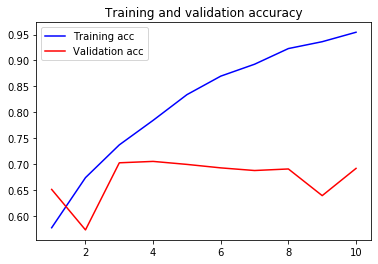

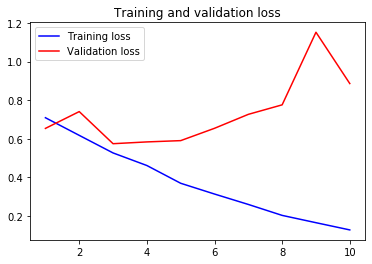

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The model reaches a validation accuracy of around 70%

Model Evaluation 

Load the test data and evaluate model performance 

In [0]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [20]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 40us/step


[0.8920598086166381, 0.68976]

Training the model wthout pretrained word embeddings :

Now let us train the same model without loading the pretrained word embeddings and without freezing the embedding layer. In this case, model will learn a taskspecific embedding of the input tokens, which is generally more powerful than
pretrained word embeddings when lots of data is available. 

In [21]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 8000 samples, validate on 10000 samples
Epoch 1/10
8000/8000 [==============================] - 2s 199us/step - loss: 0.5462 - acc: 0.7031 - val_loss: 0.3948 - val_acc: 0.8217
Epoch 2/10
8000/8000 [==============================] - 1

Plot the training /validation accuracy and loss values 

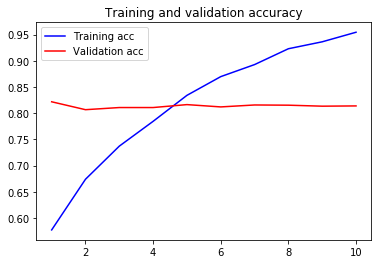

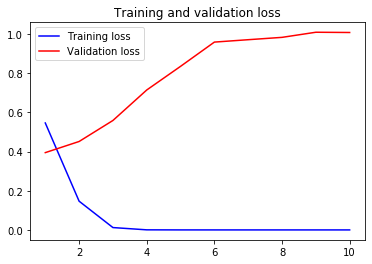

In [22]:
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In this case the model reaches a validation accuracy of around 81

Model Evaluation 

Evaluate model performance on Test data that we have already loaded

In [23]:

model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 48us/step


[0.9959731257635355, 0.81008]

We trained a model to classify IMBD reviews 
1. using pretrained GloVe word embeddings with 8000 training samples and reached a test accuracy of about 69% 
2. Without pretrained GloVe word embeddings using 8000 training samples and reached a test accuracy of about 81% 

In the original example from the book using 200 samples, the accuracy reached was around 50-55% and pretrained word embeddings seemed to perform slightly better. But with a larger data size of 8000 samples we find that te model performed better when it learns task-specific embedding of input tokens without using the pre-trained embeddings .